In [1]:
import pandas as pd
import datetime as dt
import spotipy
from secrets import spotify_secrets, localhost_db, postgres_db
from sqlalchemy import create_engine
from spotipy.oauth2 import SpotifyOAuth

In [2]:
RANGES = {'short_term': 'Short', 'medium_term': 'Medium', 'long_term': 'Long'}
LIMIT = 50

def get_user_df(sp):
    user = sp.me()
    df_user = pd.DataFrame({
        'user_id': user['id'],
        'display_name': user['display_name'],
        'spotify_url': user['external_urls']['spotify'],
        'image_url': user['images'][0]['url'],
        'followers': user['followers']['total'],
        'date_created': dt.datetime.now(),
        'last_updated': dt.datetime.now()
    }, index=[0])
    return df_user

def get_top_artists_df(sp):
    user_id = sp.me()['id']
    top_list = []
    for r in RANGES:
        top_artists = sp.current_user_top_artists(time_range=r, limit=LIMIT)
        for i, a in enumerate(top_artists['items']):
            this_top = {
                'user_id': user_id,
                'rank': i+1,
                'artist_id': a['id'],
                'timeframe': RANGES[r],
                'artist': a['name'],
                'genres': "; ".join(g for g in a['genres']),
                'artist_url': a['external_urls']['spotify'],
                'artist_image': a['images'][0]['url'],
                'popularity': a['popularity']
            }
            top_list.append(this_top)
    return pd.DataFrame.from_dict(top_list)

def get_top_tracks_df(sp):
    user_id = sp.me()['id']
    top_list = []
    for r in RANGES:
        top_tracks = sp.current_user_top_tracks(time_range=r, limit=LIMIT)
        for i, t in enumerate(top_tracks['items']):
            this_top = {
                'user_id': user_id,
                'rank': i+1,
                'track_id': t['id'],
                'timeframe': RANGES[r],
                'track_id': t['id'],
                'track': t['name'],
                'artists': "; ".join(a['name'] for a in t['artists']),
                'album': t['album']['name'],
                'album_image': t['album']['images'][0]['url'],
                'release_date': t['album']['release_date'],
                'track_url': t['external_urls']['spotify']
            }
            top_list.append(this_top)
    return pd.DataFrame.from_dict(top_list)

def get_top_genres_df(top_artists, weight=128, shift=10):
    df_genre = pd.DataFrame(columns=['user_id', 'rank', 'genre', 'points', 'timeframe'])
    user_id = top_artists['Short'][0]['user_id']
    top_genres_list = []
    for timeframe in ['Short', 'Medium', 'Long']:
        top_genres = {}
        for artist in top_artists[timeframe]:
            try:
                points = weight / ((artist['rank'] + shift) ** 2)
                genres = artist['genres'].split(';')
                for genre in genres:
                    genre = genre.strip().title()
                    if genre in top_genres:
                        top_genres[genre] += points
                    else:
                        top_genres[genre] = points
            except:
                pass
        top_genres = {k: v for k, v in sorted(top_genres.items(), key=lambda item: item[1], reverse=True)}
        genres = [g for g in list(top_genres.keys())[:LIMIT]]
        points = [p for p in list(top_genres.values())[:LIMIT]]
        user_ids = [user_id for i in range(len(top_genres))]
        ranks = [i for i in range(1, len(top_genres)+1)]
        timeframes = [timeframe for i in range(len(top_genres))]
        df_genre = df_genre.append(pd.DataFrame(list(map(list, zip(*[user_ids, ranks, genres, points, timeframes]))), \
                                                columns=['user_id', 'rank', 'genre', 'points', 'timeframe']))
    return df_genre.reset_index(drop=True)

def get_music_features_df(top_tracks):
    audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', \
                      'liveness', 'valence', 'tempo']
    df_feature = pd.DataFrame(columns=['user_id'] + audio_features + ['timeframe'])
    user_id = top_tracks['Short'][0]['user_id']
    for timeframe in ['Short', 'Medium', 'Long']:
        this_feature = {'user_id': user_id, 'timeframe': timeframe}
        all_features = sp.audio_features([t['track_id'] for t in top_tracks[timeframe]])
        for f in audio_features:
            this_feature[f] = sum(a[f] for a in all_features) / len(all_features)
        df_feature = df_feature.append(this_feature, ignore_index=True)
    return df_feature

def get_recently_played_df(sp):
    user_id = sp.me()['id']
    recently_played = sp.current_user_recently_played()
    dict_list = []
    for rp in recently_played['items']:
        this_track = {
            'user_id': user_id,
            'track': rp['track']['name'],
            'artists': "; ".join(a['name'] for a in rp['track']['artists']),
            'album': rp['track']['album']['name'],
            'release_date': rp['track']['album']['release_date'],
            'track_url': rp['track']['external_urls']['spotify'],
            'played_at': rp['played_at']
        }
        dict_list.append(this_track)
    return pd.DataFrame.from_dict(dict_list)

def get_current_playlists_df(sp):
    user_id = sp.me()['id']
    user_playlists = sp.current_user_playlists()
    dict_list = []
    for pl in user_playlists['items']:
        this_playlist = {
            'user_id': user_id,
            'playlist_id': pl['id'],
            'name': pl['name'],
            'description': pl['description'],
            'owner_display_name': pl['owner']['display_name'],
            'playlist_url': pl['external_urls']['spotify'],
            'track_numbers': pl['tracks']['total']
        }
        dict_list.append(this_playlist)
    return pd.DataFrame.from_dict(dict_list)

In [3]:
def top_to_dict(top_df):
    top_dict = {}
    top_dict['Short'] = top_df.loc[top_df['timeframe'] == 'Short'].to_dict('records')
    top_dict['Medium'] = top_df.loc[top_df['timeframe'] == 'Medium'].to_dict('records')
    top_dict['Long'] = top_df.loc[top_df['timeframe'] == 'Long'].to_dict('records')
    return top_dict

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=spotify_secrets["Client Id"],
                                               client_secret=spotify_secrets["Client Secret"],
                                               redirect_uri="http://localhost:8892/callback",
                                               scope="user-top-read"))

In [5]:
user = get_user_df(sp)
user.head()

,user_id,display_name,spotify_url,image_url,followers,date_created,last_updated
0,12120382831,Bin Xuan Kong,https://open.spotify.com/user/12120382831,https://scontent-iad3-1.xx.fbcdn.net/v/t1.0-1/...,53,2021-01-17 15:26:13.362288,2021-01-17 15:26:13.362300


In [6]:
top_artists = get_top_artists_df(sp)
top_artists.head()

,user_id,rank,artist_id,timeframe,artist,genres,artist_url,artist_image,popularity
0,12120382831,1,00FQb4jTyendYWaN8pK0wa,Short,Lana Del Rey,art pop; pop,https://open.spotify.com/artist/00FQb4jTyendYW...,https://i.scdn.co/image/d79b3e6cc42de7f44c8f13...,86
1,12120382831,2,3mIj9lX2MWuHmhNCA7LSCW,Short,The 1975,modern alternative rock; modern rock; nu gaze;...,https://open.spotify.com/artist/3mIj9lX2MWuHmh...,https://i.scdn.co/image/94dd2feca73bdfb7e1c127...,80
2,12120382831,3,3MZsBdqDrRTJihTHQrO6Dq,Short,Joji,alternative r&b; viral pop,https://open.spotify.com/artist/3MZsBdqDrRTJih...,https://i.scdn.co/image/946502271a52151aae958c...,86
3,12120382831,4,1Xyo4u8uXC1ZmMpatF05PJ,Short,The Weeknd,canadian contemporary r&b; canadian pop; pop,https://open.spotify.com/artist/1Xyo4u8uXC1ZmM...,https://i.scdn.co/image/d9a875c37277c35b94c60c...,95
4,12120382831,5,2h93pZq0e7k5yf4dywlkpM,Short,Frank Ocean,alternative r&b; hip hop; lgbtq+ hip hop; neo ...,https://open.spotify.com/artist/2h93pZq0e7k5yf...,https://i.scdn.co/image/7db34c8aace6feb91f3860...,86


In [7]:
top_tracks = get_top_tracks_df(sp)
top_tracks.head()

,user_id,rank,track_id,timeframe,track,artists,album,album_image,release_date,track_url
0,12120382831,1,73jVPicY2G9YHmzgjk69ae,Short,Robbers,The 1975,The 1975,https://i.scdn.co/image/ab67616d0000b27304f21e...,2013-01-01,https://open.spotify.com/track/73jVPicY2G9YHmz...
1,12120382831,2,6ilc4vQcwMPlvAHFfsTGng,Short,Sweet,Cigarettes After Sex,Cigarettes After Sex,https://i.scdn.co/image/ab67616d0000b27394d280...,2017-06-09,https://open.spotify.com/track/6ilc4vQcwMPlvAH...
2,12120382831,3,2Kerz9H9IejzeIpjhDJoYG,Short,Love,Lana Del Rey,Lust For Life,https://i.scdn.co/image/ab67616d0000b27395e2fd...,2017-07-21,https://open.spotify.com/track/2Kerz9H9IejzeIp...
3,12120382831,4,0w2kfnU1PFKxjmZFQ1J1X8,Short,Overthinking,Acid Ghost,I Want to Hide My Face & Die,https://i.scdn.co/image/ab67616d0000b273f09e36...,2015-11-26,https://open.spotify.com/track/0w2kfnU1PFKxjmZ...
4,12120382831,5,2p8IUWQDrpjuFltbdgLOag,Short,After Hours,The Weeknd,After Hours,https://i.scdn.co/image/ab67616d0000b2738863bc...,2020-03-20,https://open.spotify.com/track/2p8IUWQDrpjuFlt...


In [8]:
top_genres = get_top_genres_df(top_to_dict(top_artists))
top_genres.head()

,user_id,rank,genre,points,timeframe
0,12120382831,1,Pop,5.115707,Short
1,12120382831,2,Modern Rock,1.579752,Short
2,12120382831,3,Rap,1.515430,Short
3,12120382831,4,Alternative R&B,1.326285,Short
4,12120382831,5,Hip Hop,1.321412,Short


In [9]:
music_features = get_music_features_df(top_to_dict(top_tracks))
music_features.head()

,user_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timeframe
0,12120382831,0.55014,0.551302,-7.63688,0.061314,0.340714,0.061104,0.189492,0.373182,117.95160,Short
1,12120382831,0.51026,0.681540,-6.14164,0.067304,0.208833,0.038187,0.151286,0.420602,126.54000,Medium
2,12120382831,0.66128,0.625860,-6.67758,0.150006,0.217345,0.034797,0.166708,0.442180,124.22414,Long


In [10]:
artists = top_artists.drop(columns=['user_id', 'rank', 'timeframe']).drop_duplicates()
artists.head()

,artist_id,artist,genres,artist_url,artist_image,popularity
0,3mIj9lX2MWuHmhNCA7LSCW,The 1975,modern alternative rock; modern rock; nu gaze;...,https://open.spotify.com/artist/3mIj9lX2MWuHmh...,https://i.scdn.co/image/94dd2feca73bdfb7e1c127...,79
1,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,c-pop; mandopop; taiwan pop; zhongguo feng,https://open.spotify.com/artist/2elBjNSdBE2Y3f...,https://i.scdn.co/image/0e5952203ea0140aa5687f...,73
2,0fA0VVWsXO9YnASrzqfmYu,Kid Cudi,ohio hip hop; pop rap; rap,https://open.spotify.com/artist/0fA0VVWsXO9YnA...,https://i.scdn.co/image/4cb57ae1ef87546455db9c...,90
3,7CajNmpbOovFoOoasH2HaY,Calvin Harris,dance pop; edm; electro house; house; pop; pop...,https://open.spotify.com/artist/7CajNmpbOovFoO...,https://i.scdn.co/image/af53b9a94b36d4d1af3908...,86
4,0Riv2KnFcLZA3JSVryRg4y,Hiroyuki Sawano,anime score; japanese soundtrack; otacore,https://open.spotify.com/artist/0Riv2KnFcLZA3J...,https://i.scdn.co/image/7d49d81da712574ad70809...,68


In [11]:
tracks = top_tracks.drop(columns=['user_id', 'rank', 'timeframe']).drop_duplicates()
tracks.head()

,track_id,track,artists,album,album_image,release_date,track_url
0,73jVPicY2G9YHmzgjk69ae,Robbers,The 1975,The 1975,https://i.scdn.co/image/ab67616d0000b27304f21e...,2013-01-01,https://open.spotify.com/track/73jVPicY2G9YHmz...
1,6m9qPYXmhge2QhBLfFKnVF,Same Drugs,Chance the Rapper,Coloring Book,https://i.scdn.co/image/ab67616d0000b273e71dd1...,2016-05-27,https://open.spotify.com/track/6m9qPYXmhge2QhB...
2,2rtGaCAeYtmcIvuZsvgTf6,How to Disappear Completely,Radiohead,Kid A,https://i.scdn.co/image/ab67616d0000b273674c2b...,2000-10-02,https://open.spotify.com/track/2rtGaCAeYtmcIvu...
3,4C9rhLT37Gv6VMVtFCb7O1,Harvest Moon,Handsome Ghost,Harvest Moon,https://i.scdn.co/image/ab67616d0000b27300626c...,2018-01-05,https://open.spotify.com/track/4C9rhLT37Gv6VMV...
4,6ilc4vQcwMPlvAHFfsTGng,Sweet,Cigarettes After Sex,Cigarettes After Sex,https://i.scdn.co/image/ab67616d0000b27394d280...,2017-06-09,https://open.spotify.com/track/6ilc4vQcwMPlvAH...


In [12]:
engine = create_engine(postgres_db)
user.to_sql('Users', engine, index=False, if_exists='replace')
top_artists[['user_id', 'rank', 'artist_id', 'timeframe']].to_sql('TopArtists', engine, index=False, if_exists='replace')
top_tracks[['user_id', 'rank', 'track_id', 'timeframe']].to_sql('TopTracks', engine, index=False, if_exists='replace')
top_genres.to_sql('TopGenres', engine, index=False, if_exists='replace')
music_features.to_sql('MusicFeatures', engine, index=False, if_exists='replace')
artists.to_sql('Artists', engine, index=False, if_exists='replace')
tracks.to_sql('Tracks', engine, index=False, if_exists='replace')
artists.to_sql('TempArtists', engine, index=False, if_exists='replace')
tracks.to_sql('TempTracks', engine, index=False, if_exists='replace')

In [13]:
import random

ADJECTIVES = ['good', 'bad', 'new', 'old', 'first', 'last', 'long', 'short', 'little', 'big', \
              'right', 'wrong', 'high', 'short', 'large', 'small', 'different', 'same', 'best', 'worst', \
              'easy', 'difficult', 'soft', 'hard', 'major', 'minor', 'public', 'private', 'real', 'fake', \
              'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'white', 'grey', 'brown', \
              'pink', 'violet', 'indigo', 'silver', 'gold', 'teal', 'lime', 'maroon', 'olive', 'cyan']
NOUNS = ['time', 'year', 'month', 'day', 'week', 'thing', 'man', 'woman', 'boy', 'girl', \
         'world', 'life', 'eye', 'nose', 'ear', 'mouth', 'hair', 'hand', 'foot', 'leg', \
         'car', 'bus', 'bike', 'train', 'plane', 'boat', 'ship', 'tank', 'truck', 'taxi', \
         'dog', 'cat', 'mouse', 'cow', 'goat', 'horse', 'deer', 'rabbit', 'bird', 'monkey', \
         'bee', 'bear', 'chicken', 'fox', 'panda', 'frog', 'tiger', 'lion', 'duck', 'wolf']

code = random.choice(ADJECTIVES) + '-' + random.choice(NOUNS) + '-' + str(random.randint(1, 99))
code

'short-wolf-66'

In [14]:
df_profile = pd.DataFrame([['12120382831', code, True]], columns=['user_id', 'code', 'public'])
df_profile

,user_id,code,public
0,12120382831,short-wolf-66,True


In [15]:
engine = create_engine(postgres_db)
df_profile.to_sql('UserProfiles', engine, index=False, if_exists='replace')

In [16]:
engine.dispose()

In [10]:
import numpy as np
import matplotlib.pyplot as plt

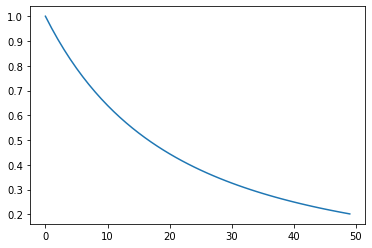

In [11]:
weight = 16
shift = 4

x = np.linspace(0, 49)
y = weight / ((0.1 * x + shift) ** 2)

plt.plot(x, y);

In [54]:
def calculate_mainstream_score(top_artists, shift=4):
    tf_weights = {'Short': 3, 'Medium': 2, 'Long': 1}
    final_score = 0
    for timeframe in ['Short', 'Medium', 'Long']:
        this_score = 0
        pop_scores = top_artists.loc[top_artists['timeframe'] == timeframe, 'popularity'].tolist()
        weights = [shift**2 / ((0.1 * i + shift) ** 2) for i in range(len(pop_scores))]
        for i, pop in enumerate(pop_scores):
            this_score += (pop**2 * weights[i]) / (100 * sum(weights))
        print(this_score)
        final_score += (this_score * tf_weights[timeframe]) / sum(tf_weights.values())
    return round(final_score)

In [55]:
calculate_mainstream_score(top_artists)

61.683732161823855
63.056637956602245
68.84987236101746


63

In [17]:
pop1 = top_artists.loc[top_artists['timeframe'] == 'Short', 'popularity'].tolist()
print(pop1)

[86, 80, 86, 95, 86, 71, 91, 87, 76, 85, 85, 76, 69, 60, 73, 80, 85, 85, 74, 64, 80, 86, 81, 79, 79, 66, 79, 72, 86, 89, 82, 73, 74, 40, 74, 70, 97, 81, 71, 61, 40, 77, 62, 71, 68, 65, 77, 53, 60, 65]


In [50]:
shift = 4
weights = [shift**2 / ((0.1 * i + shift) ** 2) for i in range(len(pop1))]
print(weights)

[1.0, 0.9518143961927424, 0.9070294784580498, 0.8653326122228232, 0.8264462809917354, 0.7901234567901234, 0.7561436672967865, 0.7243096423721139, 0.6944444444444444, 0.6663890045814242, 0.64, 0.6151480199923107, 0.5917159763313609, 0.5695977216091136, 0.5486968449931412, 0.5289256198347108, 0.5102040816326532, 0.49245921822099104, 0.4756242568370987, 0.45963803504740014, 0.4444444444444444, 0.4299919376511691, 0.4162330905306971, 0.40312421264802206, 0.39062499999999994, 0.378698224852071, 0.36730945821854916, 0.35642682111828916, 0.34602076124567466, 0.33606385213190504, 0.32653061224489793, 0.3173973417972625, 0.30864197530864196, 0.30024394820791883, 0.2921840759678597, 0.28444444444444444, 0.2770083102493075, 0.26986001011975036, 0.2629848783694937, 0.25636917160711425, 0.25, 0.24386526444139603, 0.2379535990481856, 0.23225431847873415, 0.22675736961451246, 0.22145328719723184, 0.21633315305570572, 0.21138855859426614, 0.20661157024793386, 0.20199469763918695]


In [37]:
this_score = 0
for i, pop in enumerate(pop1):
    this_score += (pop**2 * weights[i]) / (sum(weights) * 100)
this_score

60.11608283205957